# Assignment-14: Use LSTM on Donors Choose dataset

This exercise is to use LSTMs on Donors Choose dataset and make a model to predict approval of a new project proposal.

    Relevant Information : The dataset is already preprocessed and there is just 1 file:

    1. preprocessed_data.csv - Contains all the data


### OBJECTIVE : The goal is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school using LSTMs.

### We will make 3 different modles.

## Importing the data

In [1]:
# Importing the required libraries
# Warning reference : https://stackoverflow.com/questions/41658568/chunkize-warning-while-installing-gensim
# https://stackoverflow.com/questions/51312012/read-data-sets-is-deprecated-and-will-be-removed-in-a-future-version-instructio

import warnings
warnings.filterwarnings(action='ignore', category = UserWarning , module = 'gensim')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import os
import pickle
import random
from pprint import pprint
from tqdm import tqdm
from collections import Counter

import keras
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import *
from keras.callbacks import Callback
from keras.utils import np_utils 
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Embedding
from keras.layers import Convolution1D, MaxPooling1D, concatenate, LSTM
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import he_normal
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


## 1. Reading the data

In [2]:
project_data = pd.read_csv('preprocessed_data.csv')

print("Number of data points in train data", project_data.shape)
print('-'*100)
print("The attributes of data :", project_data.columns.values)


Number of data points in train data (109248, 9)
----------------------------------------------------------------------------------------------------
The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


In [3]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 9 columns):
school_state                                    109248 non-null object
teacher_prefix                                  109248 non-null object
project_grade_category                          109248 non-null object
teacher_number_of_previously_posted_projects    109248 non-null int64
project_is_approved                             109248 non-null int64
clean_categories                                109248 non-null object
clean_subcategories                             109248 non-null object
essay                                           109248 non-null object
price                                           109248 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 7.5+ MB


In [4]:
project_data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h1><font color='red'>************************************ASSIGNMENT************************************</font></h1>

## Function to calculate AUC after every epoch

In [5]:
def auc(y_true, y_pred):
    """
    This function returnsthe auc score for each epoch
    Args: (y_true, y_pred)
    """
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# <font color='red'>STEP : 1</font>
## Splitting data into Train and cross validation(or test): Stratified Sampling

In [6]:
# Creating label and feature data frame : Label- y, Features- X

y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

print("Shape of X before splitting : ", X.shape)
print("Shape of y before splitting : ", y.shape)

# train test cross-validation split
# Referance : https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train)

## Shape of the matrices

print("\nShape of X_train : ", X_train.shape, "\nShape of y_train : ", y_train.shape)
print("\nShape of X_cv : ", X_cv.shape, "\nShape of y_cv : ", y_cv.shape)
print("\nShape of X_test : ", X_test.shape, "\nShape of y_test : ", y_test.shape)

Shape of X before splitting :  (109248, 8)
Shape of y before splitting :  (109248,)

Shape of X_train :  (57355, 8) 
Shape of y_train :  (57355,)

Shape of X_cv :  (24581, 8) 
Shape of y_cv :  (24581,)

Shape of X_test :  (27312, 8) 
Shape of y_test :  (27312,)


## Computing the class_weights 

In [7]:
# https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
# NOTE:
# ***** This helps us to create a more robus model which can handle imbalanced dataset
# 1. sample_weights contains the initial class weight samples
# 2. class_weights is the dictionary which tries to give more weight to the class which is imbalanced

# # Creating sample weights
# sample_weights = compute_sample_weight('balanced', y_train)
# print('The sample weights are : ', sample_weights)
# print('Shape : ', sample_weights.shape)

# Declaring class weights using y_trains
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("Array of class weights for each class : ", class_weights)
print("\n")

# Creating the class weight dict as the fit() expects
class_weights_dict = dict(enumerate(class_weights.flatten()))
print("Dictionary of class weights : ", class_weights_dict)
print('\n')

Array of class weights for each class :  [3.3019574  0.58922334]


Dictionary of class weights :  {0: 3.3019573978123202, 1: 0.5892233408670638}




## Converting the two clases to binary variables

In [8]:
# We have class numbers for each image
print("Class label :", y_train[0:10])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_cv = keras.utils.to_categorical(y_cv, num_classes=2, dtype='int32')
y_test = keras.utils.to_categorical(y_test, num_classes=2, dtype='int32')

# Visualize
print("After converting the output into a vector : \n",y_train[0:10])
print("\nShapes : ")
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

Class label : [1 1 0 1 1 1 1 1 1 1]
After converting the output into a vector : 
 [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]

Shapes : 
(57355, 2)
(24581, 2)
(27312, 2)


### To encode the clean_categories and clean_subcategories I created a custom encode function

In [9]:
# Function to encode the values
def encode_categorical(data, vocab = None):
    """
    This function takes the categorical data and encodes them to numerical values
    
    Parameters:
    data : array of categorical data
    vocab : Vocablary on the train data. 
    
    NOTE:
    - If vocabulary is not created then first create it by calling the encode function and passing the train data.
    - returns vocabulary dictionary
    
    - If vocabulary is passed along with the new data then it transforms the trained vocabulary on the new data
    - returns encoded data
    """
    
    if vocab == None:
        
        # Creating the vocabulary
        _temp_vocab = {}
        _uniques = np.unique(data)
        
        for idx, val in enumerate(_uniques, start=1):
            _temp_vocab[val] = idx
        
        # returns the created vocabulary
        return _temp_vocab
    
    if vocab is not None:
        
        # creating the embeddings
        _embeddings = np.zeros(data.shape)
        
        for i, _cat in enumerate(data):
            _category = vocab.get(_cat)
            if _category is not None:
                _embeddings[i] = int(_category)
        
        # Returns the embeddings        
        return _embeddings

<h1><font color='red'>**********************************MODEL BUILDING**********************************</font></h1>

## BUILDING THE MODEL : 1

<img src="https://i.imgur.com/w395Yk9.png">

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Input_Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_teacher_prefix__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



# Encoding the Data

## `1. Text Data`

In [10]:
## References : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
## References : https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831
## References : https://www.kaggle.com/stacykurnikova/using-glove-embedding

### a. Finding the maximum feaures(words in essay) and the max length of essay

In [11]:
# Taking the entire data
essays = project_data["essay"].values.tolist()
count_per_para = {}
words = []

# Finding the length of each paragraph and words in it
for i,val in enumerate(tqdm(essays)):
    count_per_para[i] = len(essays[i].split())
    words.append(essays[i].split())

# Flattening the word list
max_features = []
for sublist in words:
    for item in sublist:
        max_features.append(item)
    
print("The maximum length of essay : ", max(count_per_para.values()))
print("\nThe maximum number of features(words) in the essays : ", len(max_features))
print("\nUnique words in the essay : ",len(set(max_features)))

100%|██████████| 109248/109248 [00:03<00:00, 33072.75it/s]


The maximum length of essay :  339

The maximum number of features(words) in the essays :  16540843

Unique words in the essay :  56381


### b. Declaring certain variables

In [12]:
# Since the maximum number of words in the entire dataset is 16540843 but there are only 56381 unique words
MAX_NUM_WORDS = 16540845

# For padding the essays which will be smaller in size we will need maxlen > 339
MAX_SEQUENCE_LENGTH = 350

# For initial weights we will use the GloVe vector with embedding 300 dimension
EMBEDDING_SIZE = 300

## NOTE:
1. We will 1st tokenize the essays
2. We will fit on the train data only and define the vocabulary based on the train data
3. After getting the vocabulary, we will convert the text to sequence of unique integers
4. Finally we will pad the sentences up to maximum sequence length

In [13]:
%%time
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# Preparing tokenizer
text_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

# Fitting on Train text of the dataset
text_tokenizer.fit_on_texts(X_train["essay"].tolist())

# Defining Vocabulary size
text_vocabulary_size = len(text_tokenizer.word_index)+1

# Tokenizing text to sequence of unique integers
X_train_sequence = text_tokenizer.texts_to_sequences(X_train["essay"].tolist())
X_cv_sequence = text_tokenizer.texts_to_sequences(X_cv["essay"].tolist())
X_test_sequence = text_tokenizer.texts_to_sequences(X_test["essay"].tolist())

# Applying padding for those essays who are shorter (post padding)
X_train_pad = pad_sequences(X_train_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_cv_pad = pad_sequences(X_cv_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_test_pad = pad_sequences(X_test_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print("X_train Text data shape : ", X_train_pad.shape)
print("X_cv Text data shape : ", X_cv_pad.shape)
print("X_test Text data shape : ", X_test_pad.shape)
print("The vocabulary size (based on train data) : ", text_vocabulary_size)

X_train Text data shape :  (57355, 350)
X_cv Text data shape :  (24581, 350)
X_test Text data shape :  (27312, 350)
The vocabulary size (based on train data) :  43647
CPU times: user 16.3 s, sys: 179 ms, total: 16.5 s
Wall time: 16.5 s


### c. Extract word embeddings from the Glove

In [14]:
%%time
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# Loading the whole embedding in the memory

print('Loading word vectors...')
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

129it [00:00, 1289.48it/s]

Loading word vectors...


1917495it [02:36, 12227.76it/s]

Found 1917495 word vectors.
CPU times: user 2min 33s, sys: 4.06 s, total: 2min 37s
Wall time: 2min 36s


### d. Create a weight matrix

In [15]:
%%time

# The matrix is used to initialize weights in the Embedding layer of the model
embedding_matrix = np.zeros((text_vocabulary_size, EMBEDDING_SIZE))
for word, i in text_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # if words not found, embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

CPU times: user 93.9 ms, sys: 32.2 ms, total: 126 ms
Wall time: 125 ms


### e. Making the embedding layer

## NOTE:
1. While declaring the LSTM layer, I am adding weight decay and dropouts so as to prevent the model from overfitting.
2. The regularizers' value I am taking is by experiment. I tried 0.01, 0.001, 0.0001 and 0.00001 and out of all 0.00001 gave the best results for LSTM and 0.01 gave the best results for Dense layers

In [16]:
%%time
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False
# Text data
text_data_input = Input((MAX_SEQUENCE_LENGTH,))

# Creating the embeding layer
emb_text_data = Embedding(input_dim=text_vocabulary_size, output_dim=EMBEDDING_SIZE, 
                          weights = [embedding_matrix], trainable = False)(text_data_input)

# Applying LSTM layer
emb_text_LSTM = LSTM(units = 64, kernel_regularizer = regularizers.l2(0.00001),
                     dropout=0.20, recurrent_dropout=0.20,
                     return_sequences = True)(emb_text_data)

# Flattening LSTM
text_data_flatten = Flatten()(emb_text_LSTM)

# Shape
text_data_flatten.shape

W0823 13:55:10.097953 140204618565440 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 13:55:10.122529 140204618565440 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 13:55:10.126176 140204618565440 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 13:55:10.139225 140204618565440 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

CPU times: user 5.25 s, sys: 1.5 s, total: 6.75 s
Wall time: 25.9 s


TensorShape([Dimension(None), Dimension(None)])

<font color = 'red'>======================================================================================================================</font>

## `2. Categorical`

### Giving the categorical columns to the embedding layer

### Using LabelEncoder and Custom function to encode the categorical data

### `a. school_state`

In [17]:
# Importing
from sklearn.preprocessing import LabelEncoder

# Preparing the tokenizer
school_state_tokenizer = LabelEncoder()

# Fitting on the training data
school_state_tokenizer.fit(X_train['school_state'].values)

# Defining the vocabulary size
school_state_vocab = len(school_state_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_school_state = school_state_tokenizer.transform(X_train['school_state'].values)
X_cv_school_state = school_state_tokenizer.transform(X_cv['school_state'].values)
X_test_school_state = school_state_tokenizer.transform(X_test['school_state'].values)

print("X_train school_state categorical data shape : ", X_train_school_state.shape)
print("X_cv school_state categorical data shape : ", X_cv_school_state.shape)
print("X_test school_state categorical data shape : ", X_test_school_state.shape)
print("The vocabulary size (based on train data) : ", school_state_vocab-1)
print("The vocabulary : ", school_state_tokenizer.classes_)

X_train school_state categorical data shape :  (57355,)
X_cv school_state categorical data shape :  (24581,)
X_test school_state categorical data shape :  (27312,)
The vocabulary size (based on train data) :  51
The vocabulary :  ['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']


In [18]:
## Input_school_state

# Output dimension
embedding_size = min(50, (school_state_vocab+1) // 2)

# The input dimension
school_state_input = Input((1,))

# Creating the embeding layer
school_state_embedding = Embedding(input_dim = school_state_vocab, output_dim = embedding_size)(school_state_input)

# Flattening the school_state embedings
school_state_flatten = Flatten()(school_state_embedding)

# Shape
print("Output dimension : ", embedding_size)
school_state_flatten.shape

Output dimension :  26


TensorShape([Dimension(None), Dimension(None)])

### `b. teacher_prefix`

In [19]:
# Preparing the tokenizer
teacher_prefix_tokenizer = LabelEncoder()

# Fitting on the training data
teacher_prefix_tokenizer.fit(X_train['teacher_prefix'].values)

# Defining the vocabulary size
teacher_prefix_vocab = len(teacher_prefix_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_teacher_prefix = teacher_prefix_tokenizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix = teacher_prefix_tokenizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix = teacher_prefix_tokenizer.transform(X_test['teacher_prefix'].values)

print("X_train teacher_prefix categorical data shape : ", X_train_teacher_prefix.shape)
print("X_cv teacher_prefix categorical data shape : ", X_cv_teacher_prefix.shape)
print("X_test teacher_prefix categorical data shape : ", X_test_teacher_prefix.shape)
print("The vocabulary size (based on train data) : ", teacher_prefix_vocab-1)
print("The vocabulary : ", teacher_prefix_tokenizer.classes_)

X_train teacher_prefix categorical data shape :  (57355,)
X_cv teacher_prefix categorical data shape :  (24581,)
X_test teacher_prefix categorical data shape :  (27312,)
The vocabulary size (based on train data) :  5
The vocabulary :  ['dr' 'mr' 'mrs' 'ms' 'teacher']


In [20]:
## Input_teacher_prefix

# Output dimension
embedding_size = min(50, (teacher_prefix_vocab+1) // 2)

# The input dimension
teacher_prefix_input = Input((1,))

# Creating the embeding layer
teacher_prefix_embedding = Embedding(input_dim = teacher_prefix_vocab, output_dim = embedding_size)(teacher_prefix_input)

# Flattening the school_state embedings
teacher_prefix_flatten = Flatten()(teacher_prefix_embedding)

# Shape
print("Output dimension : ", embedding_size)
teacher_prefix_flatten.shape

Output dimension :  3


TensorShape([Dimension(None), Dimension(None)])

### `c. project_grade_category`

In [21]:
# Preparing the tokenizer
pg_tokenizer = LabelEncoder()

# Fitting on the training data
pg_tokenizer.fit(X_train['project_grade_category'].values)

# Defining the vocabulary size
pg_vocab = len(pg_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_project_grade_category = pg_tokenizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category = pg_tokenizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category = pg_tokenizer.transform(X_test['project_grade_category'].values)

print("X_train project_grade_category categorical data shape : ", X_train_project_grade_category.shape)
print("X_cv project_grade_category categorical data shape : ", X_cv_project_grade_category.shape)
print("X_test project_grade_category categorical data shape : ", X_test_project_grade_category.shape)
print("The vocabulary size (based on train data) : ", pg_vocab-1)
print("The vocabulary : ", pg_tokenizer.classes_)

X_train project_grade_category categorical data shape :  (57355,)
X_cv project_grade_category categorical data shape :  (24581,)
X_test project_grade_category categorical data shape :  (27312,)
The vocabulary size (based on train data) :  4
The vocabulary :  ['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']


In [22]:
## Input_Project_grade_category

# Output dimension
embedding_size = min(50, (pg_vocab+1) // 2)

# The input dimension
project_grade_category_input = Input((1,))

# Creating the embeding layer
project_grade_category_embedding = Embedding(input_dim = pg_vocab, output_dim = embedding_size)(project_grade_category_input)

# Flattening the school_state embedings
project_grade_category_flatten = Flatten()(project_grade_category_embedding)

# Shape
print("Output dimension : ", embedding_size)
project_grade_category_flatten.shape

Output dimension :  3


TensorShape([Dimension(None), Dimension(None)])

### `d. clean_categories`

In [23]:
# Creating the vocabulary on the train data
cc_vocab = encode_categorical(X_train['clean_categories'].values)

# Defining the vocabulary size
clean_categories_vocab = len(cc_vocab) + 1

# All the unknown values which are not present in the train data will be encoded to 'ZERO'

# Creating the encodings
X_train_clean_categories = encode_categorical(X_train['clean_categories'].values, vocab = cc_vocab)
X_cv_clean_categories = encode_categorical(X_cv['clean_categories'].values, vocab = cc_vocab)
X_test_clean_categories = encode_categorical(X_test['clean_categories'].values, vocab = cc_vocab)

print("X_train clean_categories categorical data shape : ", X_train_clean_categories.shape)
print("X_cv clean_categories categorical data shape : ", X_cv_clean_categories.shape)
print("X_test clean_categories categorical data shape : ", X_test_clean_categories.shape)
print("The vocabulary size : ", clean_categories_vocab-1)
print("The vocabuary : ", list(cc_vocab.keys()))

X_train clean_categories categorical data shape :  (57355,)
X_cv clean_categories categorical data shape :  (24581,)
X_test clean_categories categorical data shape :  (27312,)
The vocabulary size :  50
The vocabuary :  ['appliedlearning', 'appliedlearning health_sports', 'appliedlearning history_civics', 'appliedlearning literacy_language', 'appliedlearning math_science', 'appliedlearning music_arts', 'appliedlearning specialneeds', 'appliedlearning warmth care_hunger', 'health_sports', 'health_sports appliedlearning', 'health_sports history_civics', 'health_sports literacy_language', 'health_sports math_science', 'health_sports music_arts', 'health_sports specialneeds', 'health_sports warmth care_hunger', 'history_civics', 'history_civics appliedlearning', 'history_civics health_sports', 'history_civics literacy_language', 'history_civics math_science', 'history_civics music_arts', 'history_civics specialneeds', 'history_civics warmth care_hunger', 'literacy_language', 'literacy_langu

In [24]:
## Input_clean_categories

# Output dimension
embedding_size = min(50, (clean_categories_vocab+1) // 2)

# The input dimension
clean_categories_input = Input((1,))

# Creating the embeding layer
clean_categories_embedding = Embedding(input_dim = clean_categories_vocab, output_dim = embedding_size)(clean_categories_input)

# Flattening the school_state embedings
clean_categories_flatten = Flatten()(clean_categories_embedding)

# Shape
print("Output dimension : ", embedding_size)
clean_categories_flatten.shape

Output dimension :  26


TensorShape([Dimension(None), Dimension(None)])

### `e. clean_subcategories`

In [25]:
# Creating the vocabulary on the train data
csc_vocab = encode_categorical(X_train['clean_subcategories'].values)

# Defining the vocabulary size
clean_sg_vocab = len(csc_vocab) + 1

# All the unknown values which are not present in the train data will be encoded to 'ZERO'

# Creating the encodings
X_train_clean_subcategories = encode_categorical(X_train['clean_subcategories'].values, vocab = csc_vocab)
X_cv_clean_subcategories = encode_categorical(X_cv['clean_subcategories'].values, vocab = csc_vocab)
X_test_clean_subcategories = encode_categorical(X_test['clean_subcategories'].values, vocab = csc_vocab)

print("X_train clean_subcategories categorical data shape : ", X_train_clean_subcategories.shape)
print("X_cv clean_subcategories categorical data shape : ", X_cv_clean_subcategories.shape)
print("X_test clean_subcategories categorical data shape : ", X_test_clean_subcategories.shape)
print("The vocabulary size (based on train data) : ", clean_sg_vocab - 1)
print("The vocabulary : ", list(csc_vocab.keys()))

X_train clean_subcategories categorical data shape :  (57355,)
X_cv clean_subcategories categorical data shape :  (24581,)
X_test clean_subcategories categorical data shape :  (27312,)
The vocabulary size (based on train data) :  379
The vocabulary :  ['appliedsciences', 'appliedsciences charactereducation', 'appliedsciences civics_government', 'appliedsciences college_careerprep', 'appliedsciences communityservice', 'appliedsciences earlydevelopment', 'appliedsciences economics', 'appliedsciences environmentalscience', 'appliedsciences esl', 'appliedsciences extracurricular', 'appliedsciences foreignlanguages', 'appliedsciences gym_fitness', 'appliedsciences health_lifescience', 'appliedsciences health_wellness', 'appliedsciences history_geography', 'appliedsciences literacy', 'appliedsciences literature_writing', 'appliedsciences mathematics', 'appliedsciences music', 'appliedsciences nutritioneducation', 'appliedsciences other', 'appliedsciences parentinvolvement', 'appliedsciences 

In [26]:
## Input_clean_subcategories

# Output dimension
embedding_size = min(50, (clean_sg_vocab+1) // 2)

# The input dimension
clean_subcategories_input = Input((1,))

# Creating the embeding layer
clean_subcategories_embedding = Embedding(input_dim = clean_sg_vocab, 
                                          output_dim = embedding_size)(clean_subcategories_input)

# Flattening the school_state embedings
clean_subcategories_flatten = Flatten()(clean_subcategories_embedding)

# Shape
print("Output dimension : ", embedding_size)
clean_subcategories_flatten.shape

Output dimension :  50


TensorShape([Dimension(None), Dimension(None)])

<font color = 'red'>======================================================================================================================</font>

## `2. Numerical data`

### Since there are only two numerical columns, so we will 1st Normalize (values ranging between 0-1) them and then pass to the dense layer.

### `a. price`

In [27]:
# Normalizing sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

price_scalar = Normalizer()

# We will fit the train data only
price_scalar.fit(X_train['price'].values.reshape(-1,1))

# Now standardize the data with above mean and variance.
X_train_price = price_scalar.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = price_scalar.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1,1))

print("Price is standardized\n")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)


Price is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


### `b. teacher_number_of_previously_posted_projects`

In [28]:
previous_post_scalar = Normalizer()

# We will fit the train data only
previous_post_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

# Now standardize the data with above mean and variance.
X_train_previous_projects = previous_post_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previous_projects = previous_post_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_projects = previous_post_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Teacher_number_of_previously_posted_projects is standardized\n")
print(X_train_previous_projects.shape, y_train.shape)
print(X_cv_previous_projects.shape, y_cv.shape)
print(X_test_previous_projects.shape, y_test.shape)


Teacher_number_of_previously_posted_projects is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


## [X] Stacking both the numerical features together

In [29]:
# Hstack for train data
X_train_nummerical = np.hstack((X_train_price, X_train_previous_projects))

# Hstack for CV data
X_cv_nummerical = np.hstack((X_cv_price, X_cv_previous_projects))

# Hstack for test data
X_test_nummerical = np.hstack((X_test_price, X_test_previous_projects))

# Shape
print("Shape of numerical data after hstacking : ")
print("Train : ", X_train_nummerical.shape)
print("Train : ", X_cv_nummerical.shape)
print("Test : ", X_test_nummerical.shape)

Shape of numerical data after hstacking : 
Train :  (57355, 2)
Train :  (24581, 2)
Test :  (27312, 2)


In [30]:
## Input for numerical data

# Since the input dimension = 2 for numerical values
num_input = Input((2,))

# Creating the dense layer
num_dense = Dense(units = 16, activation='relu', kernel_initializer = he_normal(seed=None))(num_input)

## NOTE:
1. I am adding weight decay and a kernel_initializer to the dense layer so as to avoid overfitting.

## [X] Stacking all the data together

In [31]:
# Stacking all the columns together

# Training data
X_train_data = [X_train_pad, X_train_school_state, X_train_teacher_prefix, 
                X_train_project_grade_category, X_train_clean_categories, 
                X_train_clean_subcategories, X_train_nummerical]

# CV data
X_cv_data = [X_cv_pad, X_cv_school_state, X_cv_teacher_prefix, 
             X_cv_project_grade_category, X_cv_clean_categories, 
             X_cv_clean_subcategories, X_cv_nummerical]

# Test data
X_test_data = [X_test_pad, X_test_school_state, X_test_teacher_prefix, 
               X_test_project_grade_category, X_test_clean_categories, 
               X_test_clean_subcategories, X_test_nummerical]

# [X] Building the model

# <font color='red'>MODEL : 1</font>

In [32]:
# https://stackoverflow.com/questions/51312012/read-data-sets-is-deprecated-and-will-be-removed-in-a-future-version-inst

# Sets the threshold for what messages will be logged.
old_v = tf.logging.get_verbosity()
# able to set the logging verbosity to either DEBUG, INFO, WARN, ERROR, or FATAL. Here its ERROR
tf.logging.set_verbosity(tf.logging.ERROR)

################################################################################################################

# Setting the gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#########################################################################################

# Concatinating all the features
all_features = concatenate([text_data_flatten, school_state_flatten, teacher_prefix_flatten, 
                            project_grade_category_flatten, clean_categories_flatten, 
                            clean_subcategories_flatten, num_dense])


####### 1st Dense after concatenation
input_x = Dense(units = 128, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(all_features)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 2nd Dense layer
input_x = Dense(units = 64, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(input_x)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 3rd Dense layer
input_x = Dense(units = 32, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer = regularizers.l2(0.001))(input_x)


####### Output layer
predictions = Dense(2, activation = 'softmax')(input_x)

#########################################################################################

# Declaring the model
model = Model(inputs=[text_data_input, school_state_input, teacher_prefix_input, 
                      project_grade_category_input, clean_categories_input, 
                      clean_subcategories_input, num_input], outputs = predictions)

# Compiling the model -> Calculation of loss and finding model accuracy
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# Summary
print(model.summary(), '\n')

#########################################################################################

# Callbacks

# Instantiating tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Creating checkpoints
best_model = ModelCheckpoint(filepath='checkpoints/best_model_1_weights.h5', 
                             monitor = 'val_loss', save_weights_only=True, mode = 'min')

# Early stopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2)

#########################################################################################

# Fitting data in the model
history = model.fit(X_train_data, y_train, batch_size = 800, epochs = 12, 
                    validation_data = (X_cv_data, y_cv), verbose=1, 
                    callbacks=[tensorboard_callback, best_model, early_stop], 
                    class_weight = class_weights_dict)

################################################################################################################
#in the end
tf.logging.set_verbosity(old_v)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 300)     13094100    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (I

Epoch 12/12
57355/57355 [==============================] - 289s 5ms/step - loss: 0.6250 - auc: 0.7682 - val_loss: 0.6487 - val_auc: 0.7512


## Saving the model

In [33]:
# Saving the model
model.save('checkpoints/model_1.h5')

## NOTE:
1. As we can see from the results, the validation loss starts to increase and the auc also doesn't increase much.
2. So the early_stopping stops training the model at this point.
3. As we have used regularization or so called weight decay in the layers, so there's no over fitting observed in the results.
4. The validation loss and accuracy both are better than the training loss and accuracy. This can happen because  we had used dropouts and weight decay during the training of the model which get eliminated during the validation of the model.

In [34]:
# # Loading the model
# from keras.models import load_model
# model = load_model('checkpoints/model_1.h5', compile=False)

# # Compiling the model
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# # Loading weights
# model.load_weights('checkpoints/best_model_1_weights.h5')

# print("Model loaded")

## [X] Evaluate the model

In [35]:
## Getting the scores of train data
score_train = model.evaluate(X_train_data, y_train, batch_size=400, verbose=1)
print('Train Loss:', score_train[0])
print('Train ROC_AUC:', score_train[1])
print("-"*100)

## Getting the scores of train data
score_test = model.evaluate(X_test_data, y_test, batch_size=400, verbose=1)
print('Test Loss:', score_test[0])
print('Test ROC_AUC:', score_test[1])

57355/57355 [==============================] - 76s 1ms/step
Train Loss: 0.6208737469594509
Train ROC_AUC: 0.7925851138767032
----------------------------------------------------------------------------------------------------
27312/27312 [==============================] - 35s 1ms/step
Test Loss: 0.6414192652730266
Test ROC_AUC: 0.7564098626364117


## NOTE:
1. As seen above, we have the training accuracy as 79.25% and Test accuracy as 75.64%
2. There's no overfitting in the model and the model performs very well on the unseen test data.
3. We can take the accuracy up to 80% by introducing some more data or by changing the architecture.

## [X] Visualizing the model's performance (Not the saved model)

## NOTE:
1. I extracted the csv files from the tensorboard and plotted the results using those csv files

## Function to plot the graph

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, title, label, colors=['b']):
    ax.plot(x, y, '#4287f5', label="Train {}".format(label), marker='.')
    ax.plot(x, y_1, '#f59c42', label="Validation {}".format(label), marker='.')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()

## 1. Train vs Validation loss graph 

<IPython.core.display.Javascript object>


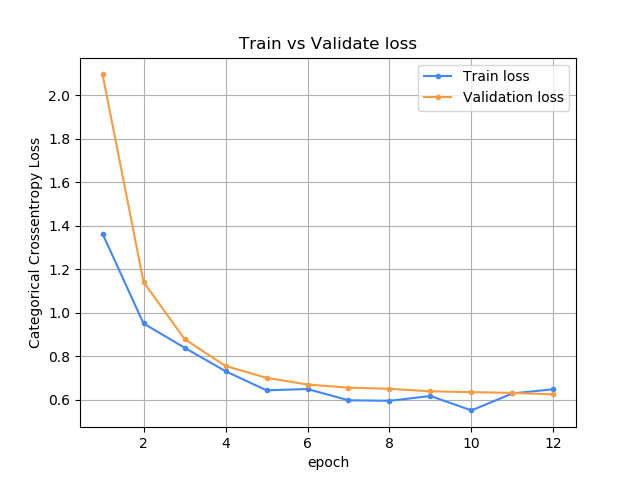

In [37]:
# Epochs
epochs = 12

# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_1_val_loss.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_1_loss.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate loss", "loss")

## 2. Train vs Validation AUC scores

<IPython.core.display.Javascript object>


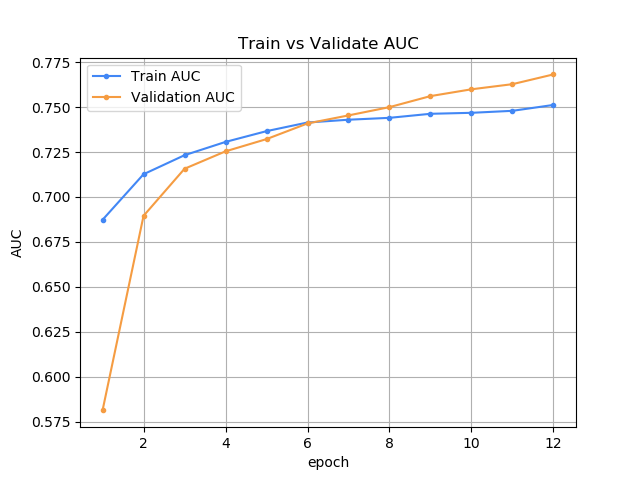

In [38]:
# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_1_val_auc.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_1_auc.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate AUC", "AUC")

## [X] Plots of Tensorboard

### 1. Train AUC

<img src = 'Results/model_1_auc.svg'>

### 2. Validation AUC

<img src = 'Results/model_1_val_auc.svg'>

### 3. Train Loss

<img src = 'Results/model_1_loss.svg'>

### 4. Validation loss

<img src = 'Results/model_1_val_loss.svg'>

## CONCLUSION

1. In the model 1, we can observe no overfitting of the model from the graphs above.
2. To reduce the overfitting of the model I have used dropouts and weights decay.
3. We can observe that the train AUC and the validation AUC have a smooth curve but the loss of validation data has some uneven curves. That means while validation it observes totally new points where it failed to classify them and so the loss increases and vice versa.
4. After the 9th epoch the model starts to overfit, so the early stopping stops the training.

## Model Architecture

<img src = 'Results/model_1.png'>

<h1><font color='red'>**********************************MODEL BUILDING**********************************</font></h1>

## BUILDING THE MODEL : 2


STEPS INVOLVED : 
<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

## 1. Training the TF-IDF on Train data

In [10]:
%%time

# Vectorizing the essay column
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the vectorizer 
vectorizer_tfidf_essay = TfidfVectorizer()

# We will fit the train data only
vectorizer_tfidf_essay.fit(X_train['essay'].values)

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)

print("Essay vectorized")
print(X_train_essay_tfidf.shape, y_train.shape)

Essay vectorized
(57355, 43716) (57355, 2)
CPU times: user 13.4 s, sys: 172 ms, total: 13.5 s
Wall time: 13.4 s


## 2. Getting the IDF values for each words

In [11]:
## https://stackoverflow.com/questions/25217510/how-to-see-top-n-entries-of-term-document-matrix-after-tfidf-in-scikit-l
## Getting the feature names

text_features = vectorizer_tfidf_essay.get_feature_names()

## Getting the idf values for the features
idf_values = vectorizer_tfidf_essay.idf_
print("Total unique Features : ", len(text_features), '\n')
print("Some feature names : ", text_features[0:10], '\n')
print("IDF matrix shape : ", idf_values.shape, '\n')
print("IDF values : ", idf_values[0:10], '\n')
print("="*100)
print("\n")

## Sorting the features as per IDF values
sorted_idf_values = np.argsort(vectorizer_tfidf_essay.idf_)

## Matching the features with their idf values
features_map = [text_features[i] for i in sorted_idf_values]

## Matching the idf_ scores
idf_map = [idf_values[i] for i in sorted_idf_values]

## Reverse idf_scores
rev_idf_scores = sorted(idf_map, reverse=True)

print("Sorted IDF values indexes (ascending) : ", sorted_idf_values[0:10])
print("Length : ", len(sorted_idf_values), '\n')
print("Features names (ascending) : ", features_map[0:10])
print("Length : ", len(features_map), '\n')
print("Ascending TFIDF values : ", idf_map[0:10])
print("Length : ", len(idf_map), '\n')
print("Descending TFIDF values : ", rev_idf_scores[0:10])
print("Length : ", len(rev_idf_scores), '\n')

Total unique Features :  43716 

Some feature names :  ['00', '000', '000s', '001', '002', '00am', '00pm', '01', '010', '01075rm'] 

IDF matrix shape :  (43716,) 

IDF values :  [ 7.21210061  5.92634748 11.26388556 10.85842045 11.26388556 10.34759483
  9.47212609 10.34759483 11.26388556 11.26388556] 



Sorted IDF values indexes (ascending) :  [37542 26084 34198 25985 22611  7757 26746 22595 39095 39219]
Length :  43716 

Features names (ascending) :  ['students', 'nannan', 'school', 'my', 'learning', 'classroom', 'not', 'learn', 'the', 'they']
Length :  43716 

Ascending TFIDF values :  [1.007683392571779, 1.046353982109022, 1.1617930778718009, 1.2473148852949676, 1.3634777422657793, 1.3917080895809715, 1.4522666135483837, 1.4625968570591041, 1.4696271048404141, 1.5085500457627146]
Length :  43716 

Descending TFIDF values :  [11.263885557274984, 11.263885557274984, 11.263885557274984, 11.263885557274984, 11.263885557274984, 11.263885557274984, 11.263885557274984, 11.263885557274984, 

## NOTE:

So now we have to remove the very low idf_ values and very high idf_ values because very low idf_ indicates too rare words and very high idf_ indicates too frequent words.

## 3. Doing analysis to find the best set of words.

In [12]:
# Combining the features and their idf_ scores
features_idfs = pd.DataFrame(zip(features_map, idf_map), columns = ['Features', 'IDF_scores'])
print("Features and IDF_ scores : \n")
pprint(features_idfs.head())

# Finding the count of the IDF_values (most frequent and most rare)
idf_values = pd.DataFrame(features_idfs['IDF_scores'].value_counts()).reset_index()
idf_values.columns = ['IDF_scores','counts']
print('\n')
print("="*50)
print('\n')
print("IDF_ scores and counts : \n")
pprint(idf_values.head())

Features and IDF_ scores : 

   Features  IDF_scores
0  students    1.007683
1    nannan    1.046354
2    school    1.161793
3        my    1.247315
4  learning    1.363478




IDF_ scores and counts : 

   IDF_scores  counts
0   11.263886   16823
1   10.858420    4980
2   10.570738    2704
3   10.347595    1819
4   10.165273    1312


## NOTE: 

1. We will remove the words which have occured less than 4 times and will remove the words with very high frequency

## a. Plotting some graphs to understand the distribution and find the thresholds

### 1. PDF and CDF curves

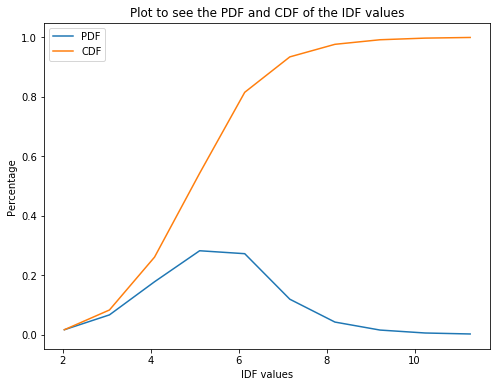

In [13]:
## PDF and CDF curves

counts, bin_edges = np.histogram(idf_values['IDF_scores'], bins = 10, density=True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)

plt.figure(figsize=(8,6))
plt.plot(bin_edges[1:], pdf, label = 'PDF')
plt.plot(bin_edges[1:], cdf, label = 'CDF')
plt.title('Plot to see the PDF and CDF of the IDF values')
plt.xlabel('IDF values')
plt.ylabel('Percentage')
plt.legend()
plt.show()

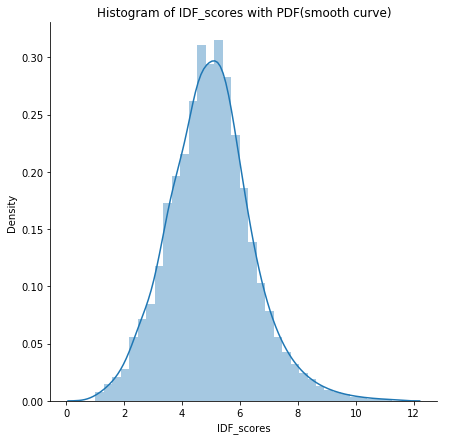

In [14]:
# PDF without removing the histograms

sns.FacetGrid(idf_values, height = 6).map(sns.distplot, 'IDF_scores').add_legend()
plt.title('Histogram of IDF_scores with PDF(smooth curve)')
plt.ylabel('Density')
plt.xlabel('IDF_scores')
plt.show()

## b. Plotting the violin plot and box plot to find the IQR

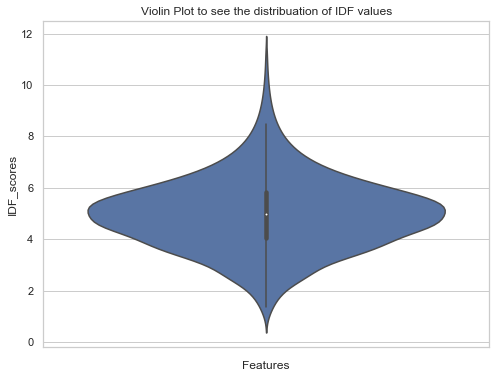

In [15]:
## Violin plot 

plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
sns.violinplot(y = 'IDF_scores', data = idf_values).set_title('Violin Plot to see the distribuation of IDF values')
plt.xlabel('Features')
plt.show()

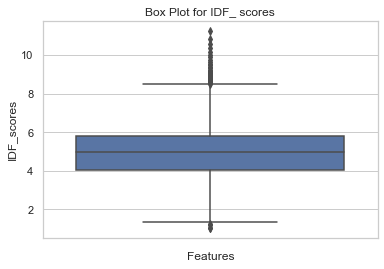

In [16]:
# Box Plot for feature 'IDF_scores'

sns.set(style="whitegrid")
sns.boxplot(y = 'IDF_scores', data = idf_values).set_title('Box Plot for IDF_ scores')
plt.xlabel("Features")
plt.show()

## NOTE:
1. From the above curves we can conclude that most of the words which are useful lie in the range of 2 - 8.
2. So we can select our threshold as words > 3 and words < 11.

## Creating a dictionary with new features

In [17]:
# Dictionary with features and IDF_ scores
old_feature_dict = {}
for i, val in zip(features_map, idf_map):
    old_feature_dict[i] = val

# Dictionary of the new features
new_features_dict = {}
for i, k in old_feature_dict.items():
    if k >= 3 and k <= 11:
        new_features_dict[i] = k
        
print("Number of features in the old vocabulary : ", len(old_feature_dict))
print("Old vocabulary : ", list(old_feature_dict.keys())[0:5])
print("Range of feature's idf_ score in the old vocabulary : ", 
      min(list(old_feature_dict.values())), "-",
      max(list(old_feature_dict.values())))

print("\nNumber of features in the new vocabulary : ", len(new_features_dict))
print("New vocabulary : ", sorted(list(new_features_dict.keys()), reverse=True)[0:5])
print("Range of feature's idf_ score in the new vocabulary : ", 
      min(list(new_features_dict.values())), "-",
      max(list(new_features_dict.values())))

Number of features in the old vocabulary :  43716
Old vocabulary :  ['students', 'nannan', 'school', 'my', 'learning']
Range of feature's idf_ score in the old vocabulary :  1.007683392571779 - 11.263885557274984

Number of features in the new vocabulary :  26753
New vocabulary :  ['zuni', 'zumba', 'zuma', 'zulu', 'zuckerberg']
Range of feature's idf_ score in the new vocabulary :  3.0030049785644706 - 10.85842044916682


## NOTE:
1. Finally we have features which are not too frequent or are too rare.
2. We will use this vocabulary for creating the embedding

## Now Creating the tokenizer for the word embeddings using the new features

### a. Declaring certain variables

In [18]:
# Since the maximum number of words in the entire dataset is 16540843 but there are only 56381 unique words
MAX_NUM_WORDS = 160000

# For padding the essays 
MAX_SEQUENCE_LENGTH = 250

# For initial weights we will use the GloVe vector with embedding 300 dimension
EMBEDDING_SIZE = 300

## NOTE:
1. We will 1st tokenize the essays using the new vocabulary
2. We will fit on the train data only
3. After getting the vocabulary, we will convert the text to sequence of unique integers
4. Finally we will pad the sentences up to maximum sequence length

In [19]:
%%time
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# Preparing tokenizer
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

# Fitting on new vocabulary
tokenizer.fit_on_texts(sorted(list(new_features_dict.keys())))

# Defining Vocabulary size
text_vocabulary_size = len(tokenizer.word_index) + 1

# Tokenizing text to sequence of unique integers
X_train_sequence = tokenizer.texts_to_sequences(X_train["essay"].tolist())
X_cv_sequence = tokenizer.texts_to_sequences(X_cv["essay"].tolist())
X_test_sequence = tokenizer.texts_to_sequences(X_test["essay"].tolist())

# Applying padding for those essays who are shorter (post padding)
X_train_pad = pad_sequences(X_train_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_cv_pad = pad_sequences(X_cv_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_test_pad = pad_sequences(X_test_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print("X_train Text data shape : ", X_train_pad.shape)
print("X_cv Text data shape : ", X_cv_pad.shape)
print("X_test Text data shape : ", X_test_pad.shape)
print("The new vocabulary size (based on new vocabulary) : ", text_vocabulary_size)
print("Words in the vocabulary : ", list(tokenizer.word_index.keys())[0:5])

X_train Text data shape :  (57355, 250)
X_cv Text data shape :  (24581, 250)
X_test Text data shape :  (27312, 250)
The new vocabulary size (based on new vocabulary) :  26754
Words in the vocabulary :  ['00', '000', '001', '00am', '00pm']
CPU times: user 8.74 s, sys: 84.1 ms, total: 8.83 s
Wall time: 8.78 s


### b. Extract word embeddings from the Glove

In [20]:
%%time
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# Loading the whole embedding in the memory

print('Loading word vectors...')
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

145it [00:00, 1048.94it/s]

Loading word vectors...


1917495it [02:36, 12273.36it/s]

Found 1917495 word vectors.
CPU times: user 2min 33s, sys: 3.44 s, total: 2min 37s
Wall time: 2min 36s


### c. Create a weight matrix

In [21]:
%%time

# The matrix is used to initialize weights in the Embedding layer of the model
embedding_matrix = np.zeros((text_vocabulary_size, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # if words not found, embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

CPU times: user 65.4 ms, sys: 8.09 ms, total: 73.5 ms
Wall time: 72.8 ms


### d. Making the embedding layer

## NOTE:
1. While declaring the LSTM layer, I am adding weight decay and dropouts so as to prevent the model from overfitting.
2. The regularizers' value I am taking is by experiment. I tried 0.01, 0.001, 0.0001 and 0.00001 and out of all 0.00001 gave the best results for LSTM and 0.01 gave the best results for Dense layers

In [22]:
%%time
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False
# Text data
text_data_input = Input((MAX_SEQUENCE_LENGTH,))

# Creating the embeding layer
emb_text_data = Embedding(input_dim=text_vocabulary_size, output_dim=EMBEDDING_SIZE, 
                          weights = [embedding_matrix], trainable = False)(text_data_input)

# Applying LSTM layer
emb_text_LSTM = LSTM(units = 64, kernel_regularizer = regularizers.l2(0.00001),
                     dropout=0.30, recurrent_dropout=0.20,
                     return_sequences = True)(emb_text_data)

# Flattening LSTM
text_data_flatten = Flatten()(emb_text_LSTM)

# Shape
text_data_flatten.shape

W0823 15:12:48.428887 140169642231616 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 15:12:48.450703 140169642231616 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 15:12:48.453829 140169642231616 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 15:12:48.464250 140169642231616 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

CPU times: user 2.26 s, sys: 319 ms, total: 2.58 s
Wall time: 2.48 s


TensorShape([Dimension(None), Dimension(None)])

<font color = 'red'>======================================================================================================================</font>

## `2. Categorical`

### Giving the categorical columns to the embedding layer

### Using HashingVectorizer to encode the categorical data

### `a. school_state`

In [23]:
# Importing
from sklearn.preprocessing import LabelEncoder

# Preparing the tokenizer
school_state_tokenizer = LabelEncoder()

# Fitting on the training data
school_state_tokenizer.fit(X_train['school_state'].values)

# Defining the vocabulary size
school_state_vocab = len(school_state_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_school_state = school_state_tokenizer.transform(X_train['school_state'].values)
X_cv_school_state = school_state_tokenizer.transform(X_cv['school_state'].values)
X_test_school_state = school_state_tokenizer.transform(X_test['school_state'].values)

print("X_train school_state categorical data shape : ", X_train_school_state.shape)
print("X_cv school_state categorical data shape : ", X_cv_school_state.shape)
print("X_test school_state categorical data shape : ", X_test_school_state.shape)
print("The vocabulary size (based on train data) : ", school_state_vocab-1)
print("The vocabulary : ", school_state_tokenizer.classes_)

X_train school_state categorical data shape :  (57355,)
X_cv school_state categorical data shape :  (24581,)
X_test school_state categorical data shape :  (27312,)
The vocabulary size (based on train data) :  51
The vocabulary :  ['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']


In [24]:
## Input_school_state

# Output dimension
embedding_size = min(50, (school_state_vocab+1) // 2)

# The input dimension
school_state_input = Input((1,))

# Creating the embeding layer
school_state_embedding = Embedding(input_dim = school_state_vocab, output_dim = embedding_size)(school_state_input)

# Flattening the school_state embedings
school_state_flatten = Flatten()(school_state_embedding)

# Shape
print("Output dimension : ", embedding_size)
school_state_flatten.shape

Output dimension :  26


TensorShape([Dimension(None), Dimension(None)])

### `b. teacher_prefix`

In [25]:
# Preparing the tokenizer
teacher_prefix_tokenizer = LabelEncoder()

# Fitting on the training data
teacher_prefix_tokenizer.fit(X_train['teacher_prefix'].values)

# Defining the vocabulary size
teacher_prefix_vocab = len(teacher_prefix_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_teacher_prefix = teacher_prefix_tokenizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix = teacher_prefix_tokenizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix = teacher_prefix_tokenizer.transform(X_test['teacher_prefix'].values)

print("X_train teacher_prefix categorical data shape : ", X_train_teacher_prefix.shape)
print("X_cv teacher_prefix categorical data shape : ", X_cv_teacher_prefix.shape)
print("X_test teacher_prefix categorical data shape : ", X_test_teacher_prefix.shape)
print("The vocabulary size (based on train data) : ", teacher_prefix_vocab-1)
print("The vocabulary : ", teacher_prefix_tokenizer.classes_)

X_train teacher_prefix categorical data shape :  (57355,)
X_cv teacher_prefix categorical data shape :  (24581,)
X_test teacher_prefix categorical data shape :  (27312,)
The vocabulary size (based on train data) :  5
The vocabulary :  ['dr' 'mr' 'mrs' 'ms' 'teacher']


In [26]:
## Input_teacher_prefix

# Output dimension
embedding_size = min(50, (teacher_prefix_vocab+1) // 2)

# The input dimension
teacher_prefix_input = Input((1,))

# Creating the embeding layer
teacher_prefix_embedding = Embedding(input_dim = teacher_prefix_vocab, output_dim = embedding_size)(teacher_prefix_input)

# Flattening the school_state embedings
teacher_prefix_flatten = Flatten()(teacher_prefix_embedding)

# Shape
print("Output dimension : ", embedding_size)
teacher_prefix_flatten.shape

Output dimension :  3


TensorShape([Dimension(None), Dimension(None)])

### `c. project_grade_category`

In [27]:
# Preparing the tokenizer
pg_tokenizer = LabelEncoder()

# Fitting on the training data
pg_tokenizer.fit(X_train['project_grade_category'].values)

# Defining the vocabulary size
pg_vocab = len(pg_tokenizer.classes_) + 1

# Tokenizing the categorical texts to unique integers
X_train_project_grade_category = pg_tokenizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category = pg_tokenizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category = pg_tokenizer.transform(X_test['project_grade_category'].values)

print("X_train project_grade_category categorical data shape : ", X_train_project_grade_category.shape)
print("X_cv project_grade_category categorical data shape : ", X_cv_project_grade_category.shape)
print("X_test project_grade_category categorical data shape : ", X_test_project_grade_category.shape)
print("The vocabulary size (based on train data) : ", pg_vocab-1)
print("The vocabulary : ", pg_tokenizer.classes_)

X_train project_grade_category categorical data shape :  (57355,)
X_cv project_grade_category categorical data shape :  (24581,)
X_test project_grade_category categorical data shape :  (27312,)
The vocabulary size (based on train data) :  4
The vocabulary :  ['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']


In [28]:
## Input_Project_grade_category

# Output dimension
embedding_size = min(50, (pg_vocab+1) // 2)

# The input dimension
project_grade_category_input = Input((1,))

# Creating the embeding layer
project_grade_category_embedding = Embedding(input_dim = pg_vocab, output_dim = embedding_size)(project_grade_category_input)

# Flattening the school_state embedings
project_grade_category_flatten = Flatten()(project_grade_category_embedding)

# Shape
print("Output dimension : ", embedding_size)
project_grade_category_flatten.shape

Output dimension :  3


TensorShape([Dimension(None), Dimension(None)])

### `d. clean_categories`

In [29]:
# Creating the vocabulary on the train data
cc_vocab = encode_categorical(X_train['clean_categories'].values)

# Defining the vocabulary size
clean_categories_vocab = len(cc_vocab) + 1

# All the unknown values which are not present in the train data will be encoded to 'ZERO'

# Creating the encodings
X_train_clean_categories = encode_categorical(X_train['clean_categories'].values, vocab = cc_vocab)
X_cv_clean_categories = encode_categorical(X_cv['clean_categories'].values, vocab = cc_vocab)
X_test_clean_categories = encode_categorical(X_test['clean_categories'].values, vocab = cc_vocab)

print("X_train clean_categories categorical data shape : ", X_train_clean_categories.shape)
print("X_cv clean_categories categorical data shape : ", X_cv_clean_categories.shape)
print("X_test clean_categories categorical data shape : ", X_test_clean_categories.shape)
print("The vocabulary size : ", clean_categories_vocab-1)
print("The vocabuary : ", list(cc_vocab.keys()))

X_train clean_categories categorical data shape :  (57355,)
X_cv clean_categories categorical data shape :  (24581,)
X_test clean_categories categorical data shape :  (27312,)
The vocabulary size :  50
The vocabuary :  ['appliedlearning', 'appliedlearning health_sports', 'appliedlearning history_civics', 'appliedlearning literacy_language', 'appliedlearning math_science', 'appliedlearning music_arts', 'appliedlearning specialneeds', 'appliedlearning warmth care_hunger', 'health_sports', 'health_sports appliedlearning', 'health_sports history_civics', 'health_sports literacy_language', 'health_sports math_science', 'health_sports music_arts', 'health_sports specialneeds', 'health_sports warmth care_hunger', 'history_civics', 'history_civics appliedlearning', 'history_civics health_sports', 'history_civics literacy_language', 'history_civics math_science', 'history_civics music_arts', 'history_civics specialneeds', 'literacy_language', 'literacy_language appliedlearning', 'literacy_langu

In [30]:
## Input_clean_categories

# Output dimension
embedding_size = min(50, (clean_categories_vocab+1) // 2)

# The input dimension
clean_categories_input = Input((1,))

# Creating the embeding layer
clean_categories_embedding = Embedding(input_dim = clean_categories_vocab, output_dim = embedding_size)(clean_categories_input)

# Flattening the school_state embedings
clean_categories_flatten = Flatten()(clean_categories_embedding)

# Shape
print("Output dimension : ", embedding_size)
clean_categories_flatten.shape

Output dimension :  26


TensorShape([Dimension(None), Dimension(None)])

### `e. clean_subcategories`

In [31]:
# Creating the vocabulary on the train data
csc_vocab = encode_categorical(X_train['clean_subcategories'].values)

# Defining the vocabulary size
clean_sg_vocab = len(csc_vocab) + 1

# All the unknown values which are not present in the train data will be encoded to 'ZERO'

# Creating the encodings
X_train_clean_subcategories = encode_categorical(X_train['clean_subcategories'].values, vocab = csc_vocab)
X_cv_clean_subcategories = encode_categorical(X_cv['clean_subcategories'].values, vocab = csc_vocab)
X_test_clean_subcategories = encode_categorical(X_test['clean_subcategories'].values, vocab = csc_vocab)

print("X_train clean_subcategories categorical data shape : ", X_train_clean_subcategories.shape)
print("X_cv clean_subcategories categorical data shape : ", X_cv_clean_subcategories.shape)
print("X_test clean_subcategories categorical data shape : ", X_test_clean_subcategories.shape)
print("The vocabulary size (based on train data) : ", clean_sg_vocab - 1)
print("The vocabulary : ", list(csc_vocab.keys()))

X_train clean_subcategories categorical data shape :  (57355,)
X_cv clean_subcategories categorical data shape :  (24581,)
X_test clean_subcategories categorical data shape :  (27312,)
The vocabulary size (based on train data) :  378
The vocabulary :  ['appliedsciences', 'appliedsciences charactereducation', 'appliedsciences civics_government', 'appliedsciences college_careerprep', 'appliedsciences communityservice', 'appliedsciences earlydevelopment', 'appliedsciences economics', 'appliedsciences environmentalscience', 'appliedsciences esl', 'appliedsciences extracurricular', 'appliedsciences financialliteracy', 'appliedsciences foreignlanguages', 'appliedsciences gym_fitness', 'appliedsciences health_lifescience', 'appliedsciences health_wellness', 'appliedsciences history_geography', 'appliedsciences literacy', 'appliedsciences literature_writing', 'appliedsciences mathematics', 'appliedsciences music', 'appliedsciences nutritioneducation', 'appliedsciences other', 'appliedsciences 

In [32]:
## Input_clean_subcategories

# Output dimension
embedding_size = min(50, (clean_sg_vocab+1) // 2)

# The input dimension
clean_subcategories_input = Input((1,))

# Creating the embeding layer
clean_subcategories_embedding = Embedding(input_dim = clean_sg_vocab, 
                                          output_dim = embedding_size)(clean_subcategories_input)

# Flattening the school_state embedings
clean_subcategories_flatten = Flatten()(clean_subcategories_embedding)

# Shape
print("Output dimension : ", embedding_size)
clean_subcategories_flatten.shape

Output dimension :  50


TensorShape([Dimension(None), Dimension(None)])

<font color = 'red'>======================================================================================================================</font>

## `2. Numerical data`

### Since there are only two numerical columns, so we will 1st Normalize (values ranging between 0-1) them and then pass to the dense layer.

### `a. price`

In [33]:
# Normalizing sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

price_scalar = Normalizer()

# We will fit the train data only
price_scalar.fit(X_train['price'].values.reshape(-1,1))

# Now standardize the data with above mean and variance.
X_train_price = price_scalar.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = price_scalar.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1,1))

print("Price is standardized\n")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)


Price is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


### `b. teacher_number_of_previously_posted_projects`

In [34]:
previous_post_scalar = Normalizer()

# We will fit the train data only
previous_post_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

# Now standardize the data with above mean and variance.
X_train_previous_projects = previous_post_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previous_projects = previous_post_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_projects = previous_post_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Teacher_number_of_previously_posted_projects is standardized\n")
print(X_train_previous_projects.shape, y_train.shape)
print(X_cv_previous_projects.shape, y_cv.shape)
print(X_test_previous_projects.shape, y_test.shape)


Teacher_number_of_previously_posted_projects is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


## [X] Stacking both the numerical features together

In [35]:
# Hstack for train data
X_train_nummerical = np.hstack((X_train_price, X_train_previous_projects))

# Hstack for CV data
X_cv_nummerical = np.hstack((X_cv_price, X_cv_previous_projects))

# Hstack for test data
X_test_nummerical = np.hstack((X_test_price, X_test_previous_projects))

# Shape
print("Shape of numerical data after hstacking : ")
print("Train : ", X_train_nummerical.shape)
print("Train : ", X_cv_nummerical.shape)
print("Test : ", X_test_nummerical.shape)

Shape of numerical data after hstacking : 
Train :  (57355, 2)
Train :  (24581, 2)
Test :  (27312, 2)


In [36]:
## Input for numerical data

# Since the input dimension = 2 for numerical values
num_input = Input((2,))

# Creating the dense layer
num_dense = Dense(units = 16, activation='relu', kernel_initializer = he_normal(seed=None))(num_input)

## NOTE:
1. I am adding weight decay and a kernel_initializer to the dense layer so as to avoid overfitting.

## [X] Stacking all the data together

In [37]:
# Stacking all the columns together

# Training data
X_train_data = [X_train_pad, X_train_school_state, X_train_teacher_prefix, 
                X_train_project_grade_category, X_train_clean_categories, 
                X_train_clean_subcategories, X_train_nummerical]

# CV data
X_cv_data = [X_cv_pad, X_cv_school_state, X_cv_teacher_prefix, 
             X_cv_project_grade_category, X_cv_clean_categories, 
             X_cv_clean_subcategories, X_cv_nummerical]

# Test data
X_test_data = [X_test_pad, X_test_school_state, X_test_teacher_prefix, 
               X_test_project_grade_category, X_test_clean_categories, 
               X_test_clean_subcategories, X_test_nummerical]

# [X] Building the model

# <font color='red'>MODEL : 2</font>

In [38]:
# https://stackoverflow.com/questions/51312012/read-data-sets-is-deprecated-and-will-be-removed-in-a-future-version-inst

# Sets the threshold for what messages will be logged.
old_v = tf.logging.get_verbosity()
# able to set the logging verbosity to either DEBUG, INFO, WARN, ERROR, or FATAL. Here its ERROR
tf.logging.set_verbosity(tf.logging.ERROR)

################################################################################################################

# Setting the gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#########################################################################################

# Concatinating all the features
all_features = concatenate([text_data_flatten, school_state_flatten, teacher_prefix_flatten, 
                            project_grade_category_flatten, clean_categories_flatten, 
                            clean_subcategories_flatten, num_dense])


####### 1st Dense after concatenation
input_x = Dense(units = 128, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(all_features)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 2nd Dense layer
input_x = Dense(units = 64, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(input_x)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 3rd Dense layer
input_x = Dense(units = 32, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer = regularizers.l2(0.001))(input_x)


####### Output layer
predictions = Dense(2, activation = 'softmax')(input_x)

#########################################################################################

# Declaring the model
model = Model(inputs=[text_data_input, school_state_input, teacher_prefix_input, 
                      project_grade_category_input, clean_categories_input, 
                      clean_subcategories_input, num_input], outputs = predictions)

# Compiling the model -> Calculation of loss and finding model accuracy
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# Summary
print(model.summary(), '\n')

#########################################################################################

# Callbacks

# Instantiating tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Creating checkpoints
best_model = ModelCheckpoint(filepath='checkpoints/best_model_2_weights.h5', 
                             monitor = 'val_loss', save_weights_only=True, mode = 'min')

# Early stopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2)

#########################################################################################

# Fitting data in the model
history = model.fit(X_train_data, y_train, batch_size = 800, epochs = 12, 
                    validation_data = (X_cv_data, y_cv), verbose=1, 
                    callbacks=[tensorboard_callback, best_model, early_stop], 
                    class_weight = class_weights_dict)

################################################################################################################
#in the end
tf.logging.set_verbosity(old_v)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 300)     8026200     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (I

## Saving the model

In [39]:
# Saving the model
model.save('checkpoints/model_2.h5')

## NOTE:
1. As we can see from the results, the validation loss decreases after the 7th epoch.
2. So the early stopping stops training the model at this point.
3. As we have used regularization or so called weight decay in the layers, so there's no over fitting observed in the results.
4. The validation loss and accuracy both are better than the training loss and accuracy. This can happen because  we had used dropouts and weight decay during the training of the model which get eliminated during the validation of the model.

In [40]:
# # Loading the model
# from keras.models import load_model
# model = load_model('checkpoints/model_2.h5', compile=False)

# # Compiling the model
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# # Loading weights
# model.load_weights('checkpoints/best_model_2_weights.h5')

# print("Model loaded")

## [X] Evaluate the model

In [41]:
## Getting the scores of train data
score_train = model.evaluate(X_train_data, y_train, batch_size=800, verbose=1)
print('Train Loss:', score_train[0])
print('Train ROC_AUC:', score_train[1])
print("-"*100)

## Getting the scores of train data
score_test = model.evaluate(X_test_data, y_test, batch_size=800, verbose=1)
print('Test Loss:', score_test[0])
print('Test ROC_AUC:', score_test[1])

57355/57355 [==============================] - 53s 929us/step
Train Loss: 0.6293663134103914
Train ROC_AUC: 0.7520625801865917
----------------------------------------------------------------------------------------------------
27312/27312 [==============================] - 28s 1ms/step
Test Loss: 0.6416577955890135
Test ROC_AUC: 0.7305881261619023


## NOTE:
1. As seen above, we have the training accuracy as 75.20% and Test accuracy as 73.05%
2. There's no overfitting in the model and the model performs very well on the unseen test data.
3. We can take the accuracy up to 80% by introducing some more data or by changing the architecture.

## [X] Visualizing the model's performance (Not the saved model)

## NOTE:
1. I extracted the csv files from the tensorboard and plotted the results using those csv files

## Function to plot the graph

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, title, label, colors=['b']):
    ax.plot(x, y, '#4287f5', label="Train {}".format(label), marker='.')
    ax.plot(x, y_1, '#f59c42', label="Validation {}".format(label), marker='.')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()

## 1. Train vs Validation loss graph 

<IPython.core.display.Javascript object>


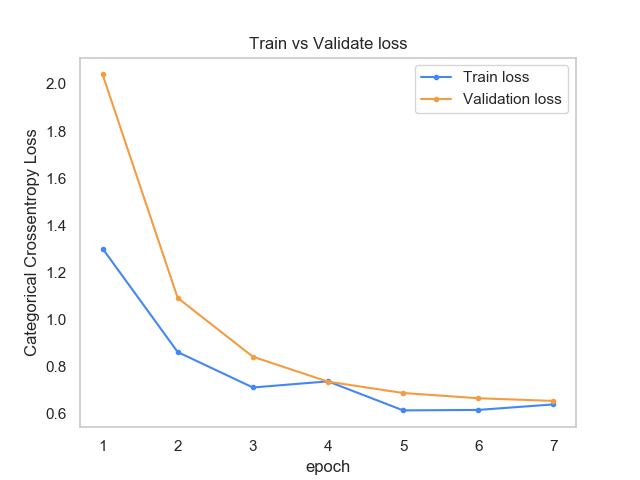

In [43]:
# Epochs
epochs = 7

# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_2_val_loss.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_2_loss.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate loss", "loss")

## 2. Train vs Validation AUC scores

<IPython.core.display.Javascript object>


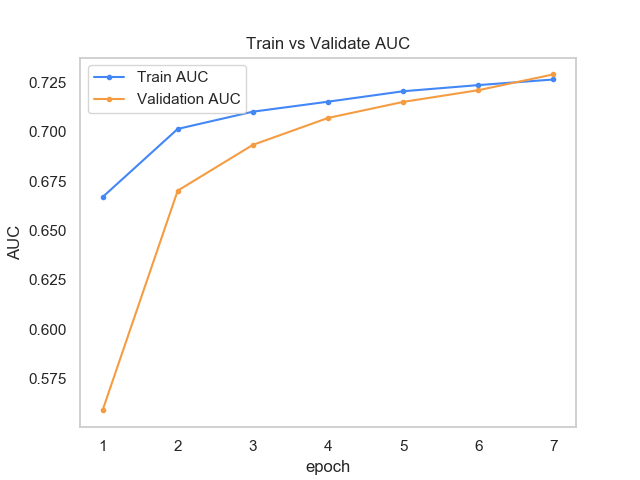

In [44]:
# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_2_val_auc.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_2_auc.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate AUC", "AUC")

## [X] Plots of Tensorboard

### 1. Train AUC

<img src = 'Results/model_2_auc.svg'>

### 2. Validation AUC

<img src = 'Results/model_2_val_auc.svg'>

### 3. Train Loss

<img src = 'Results/model_2_loss.svg'>

### 4. Validation loss

<img src = 'Results/model_2_val_loss.svg'>

## CONCLUSION

1. In the model 2, we can observe that the validation loss decreases but not as smooth as train loss.
2. To reduce the overfitting of the model I have used dropouts and weights decay.
3. We can observe that the train AUC and the validation AUC have a smooth curve but the loss of validation data has some uneven curves. That means while validation it observes totally new points where it failed to classify them and so the loss increases and vice versa.

## Model architecture

<img src = 'Results/model_2.png'>

<h1><font color='red'>**********************************MODEL BUILDING**********************************</font></h1>

## BUILDING THE MODEL : 3

<img src="https://i.imgur.com/fkQ8nGo.png">


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

# Encoding the Data

## `1. Text Data`

In [10]:
## References : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
## References : https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831
## References : https://www.kaggle.com/stacykurnikova/using-glove-embedding

### a. Finding the maximum feaures(words in essay) and the max length of essay

In [11]:
# Taking the entire data
essays = project_data["essay"].values.tolist()
count_per_para = {}
words = []

# Finding the length of each paragraph and words in it
for i,val in enumerate(tqdm(essays)):
    count_per_para[i] = len(essays[i].split())
    words.append(essays[i].split())

# Flattening the word list
max_features = []
for sublist in words:
    for item in sublist:
        max_features.append(item)
    
print("The maximum length of essay : ", max(count_per_para.values()))
print("\nThe maximum number of features(words) in the essays : ", len(max_features))
print("\nUnique words in the essay : ",len(set(max_features)))

100%|██████████| 109248/109248 [00:03<00:00, 34762.96it/s]


The maximum length of essay :  339

The maximum number of features(words) in the essays :  16540843

Unique words in the essay :  56381


### b. Declaring certain variables

In [12]:
# Since the maximum number of words in the entire dataset is 16540843 but there are only 56381 unique words
MAX_NUM_WORDS = 16540845

# For padding the essays which will be smaller in size we will need maxlen > 339
MAX_SEQUENCE_LENGTH = 350

# For initial weights we will use the GloVe vector with embedding 300 dimension
EMBEDDING_SIZE = 300

## NOTE:
1. We will 1st tokenize the essays
2. We will fit on the train data only and define the vocabulary based on the train data
3. After getting the vocabulary, we will convert the text to sequence of unique integers
4. Finally we will pad the sentences up to maximum sequence length

In [13]:
%%time
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# Preparing tokenizer
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

# Fitting on Train text of the dataset
tokenizer.fit_on_texts(X_train["essay"].tolist())

# Defining Vocabulary size
text_vocabulary_size = len(tokenizer.word_index) + 1

# Tokenizing text to sequence of unique integers
X_train_sequence = tokenizer.texts_to_sequences(X_train["essay"].tolist())
X_cv_sequence = tokenizer.texts_to_sequences(X_cv["essay"].tolist())
X_test_sequence = tokenizer.texts_to_sequences(X_test["essay"].tolist())

# Applying padding for those essays who are shorter (post padding)
X_train_pad = pad_sequences(X_train_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_cv_pad = pad_sequences(X_cv_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
X_test_pad = pad_sequences(X_test_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print("X_train Text data shape : ", X_train_pad.shape)
print("X_cv Text data shape : ", X_cv_pad.shape)
print("X_test Text data shape : ", X_test_pad.shape)
print("The vocabulary size (based on train data) : ", text_vocabulary_size)

X_train Text data shape :  (57355, 350)
X_cv Text data shape :  (24581, 350)
X_test Text data shape :  (27312, 350)
The vocabulary size (based on train data) :  43774
CPU times: user 17.1 s, sys: 139 ms, total: 17.3 s
Wall time: 17.3 s


### c. Extract word embeddings from the Glove

In [14]:
%%time
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# Loading the whole embedding in the memory

print('Loading word vectors...')
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

1209it [00:00, 12088.51it/s]

Loading word vectors...


1917495it [02:36, 12255.12it/s]

Found 1917495 word vectors.
CPU times: user 2min 35s, sys: 3.41 s, total: 2min 38s
Wall time: 2min 36s


### d. Create a weight matrix

In [15]:
%%time

# The matrix is used to initialize weights in the Embedding layer of the model
embedding_matrix = np.zeros((text_vocabulary_size, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # if words not found, embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

CPU times: user 76.1 ms, sys: 28.2 ms, total: 104 ms
Wall time: 103 ms


### e. Making the embedding layer

## NOTE:
1. While declaring the LSTM layer, I am adding weight decay and dropouts so as to prevent the model from overfitting.
2. The regularizers' value I am taking is by experiment. I tried 0.01, 0.001, 0.0001 and 0.00001 and out of all 0.00001 gave the best results for LSTM and 0.01 gave the best results for Dense layers

In [16]:
%%time
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False
# Text data
text_data_input = Input((MAX_SEQUENCE_LENGTH,))

# Creating the embeding layer
emb_text_data = Embedding(text_vocabulary_size, EMBEDDING_SIZE, weights = [embedding_matrix], 
                          trainable = False)(text_data_input)

# Applying LSTM layer
emb_text_LSTM = LSTM(units = 64, kernel_regularizer = regularizers.l2(0.00001),
                     dropout=0.30, recurrent_dropout=0.20,
                     return_sequences = True)(emb_text_data)

# Flattening LSTM
text_data_flatten = Flatten()(emb_text_LSTM)

# Shape
text_data_flatten.shape

W0823 15:47:01.955826 140139299178304 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 15:47:01.979854 140139299178304 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 15:47:01.986308 140139299178304 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 15:47:02.000638 140139299178304 deprecation_wrapper.py:119] From /home/manas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

CPU times: user 2.12 s, sys: 314 ms, total: 2.43 s
Wall time: 2.29 s


TensorShape([Dimension(None), Dimension(None)])

<font color = 'red'>======================================================================================================================</font>

## `2. Categorical data and numerical data`

### Converting all the Categorical values and numerical data to onehot encoded vectors

### `a. school_state`

In [17]:
# We use count vectorizer to convert the values into one hot encoded features
vectorizer_school_state = CountVectorizer()

# We will fit the train data only
vectorizer_school_state.fit(X_train['school_state'].values)

# Defining Vocabulary size
st_vocabulary_size = len(vectorizer_school_state.vocabulary_)

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state = np.array(vectorizer_school_state.transform(X_train['school_state'].values).todense())
X_cv_school_state = np.array(vectorizer_school_state.transform(X_cv['school_state'].values).todense())
X_test_school_state = np.array(vectorizer_school_state.transform(X_test['school_state'].values).todense())

print("X_train school_state categorical data shape : ", X_train_school_state.shape)
print("X_cv school_state categorical data shape : ", X_cv_school_state.shape)
print("X_test school_state categorical data shape : ", X_test_school_state.shape)
print("The vocabulary size (based on train data) : ", st_vocabulary_size)


X_train school_state categorical data shape :  (57355, 51)
X_cv school_state categorical data shape :  (24581, 51)
X_test school_state categorical data shape :  (27312, 51)
The vocabulary size (based on train data) :  51


### `b. teacher_prefix`

In [18]:
# We use count vectorizer to convert the values into one hot encoded features
vectorizer_teacher_prefix = CountVectorizer()

# We will fit the train data only
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values)

# Defining Vocabulary size
tp_vocabulary_size = len(vectorizer_teacher_prefix.vocabulary_)

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = np.array(vectorizer_teacher_prefix.transform(X_train['teacher_prefix'].values).todense())
X_cv_teacher_prefix = np.array(vectorizer_teacher_prefix.transform(X_cv['teacher_prefix'].values).todense())
X_test_teacher_prefix = np.array(vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values).todense())

print("X_train teacher_prefix categorical data shape : ", X_train_teacher_prefix.shape)
print("X_cv teacher_prefix categorical data shape : ", X_cv_teacher_prefix.shape)
print("X_test teacher_prefix categorical data shape : ", X_test_teacher_prefix.shape)
print("The vocabulary size (based on train data) : ", tp_vocabulary_size)


X_train teacher_prefix categorical data shape :  (57355, 5)
X_cv teacher_prefix categorical data shape :  (24581, 5)
X_test teacher_prefix categorical data shape :  (27312, 5)
The vocabulary size (based on train data) :  5


### `c. project_grade_category`

In [19]:
# We use count vectorizer to convert the values into one hot encoded features
vectorizer_project_grade_category = CountVectorizer()

# We will fit the train data only
vectorizer_project_grade_category.fit(X_train['project_grade_category'].values)

# Defining Vocabulary size
pgc_vocabulary_size = len(vectorizer_project_grade_category.vocabulary_)

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category = np.array(vectorizer_project_grade_category.transform(X_train['project_grade_category'].values).todense())
X_cv_project_grade_category = np.array(vectorizer_project_grade_category.transform(X_cv['project_grade_category'].values).todense())
X_test_project_grade_category = np.array(vectorizer_project_grade_category.transform(X_test['project_grade_category'].values).todense())

print("X_train project_grade_category categorical data shape : ", X_train_project_grade_category.shape)
print("X_cv project_grade_category categorical data shape : ", X_cv_project_grade_category.shape)
print("X_test project_grade_category categorical data shape : ", X_test_project_grade_category.shape)
print("The vocabulary size (based on train data) : ", pgc_vocabulary_size)


X_train project_grade_category categorical data shape :  (57355, 4)
X_cv project_grade_category categorical data shape :  (24581, 4)
X_test project_grade_category categorical data shape :  (27312, 4)
The vocabulary size (based on train data) :  4


### `d. clean_categories`

In [20]:
# We use count vectorizer to convert the values into one hot encoded features
vectorizer_clean_categories = CountVectorizer()

# We will fit the train data only
vectorizer_clean_categories.fit(X_train['clean_categories'].values)

# Defining Vocabulary size
ccat_vocabulary_size = len(vectorizer_clean_categories.vocabulary_)

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories = np.array(vectorizer_clean_categories.transform(X_train['clean_categories'].values).todense())
X_cv_clean_categories = np.array(vectorizer_clean_categories.transform(X_cv['clean_categories'].values).todense())
X_test_clean_categories = np.array(vectorizer_clean_categories.transform(X_test['clean_categories'].values).todense())

print("X_train clean_categories categorical data shape : ", X_train_clean_categories.shape)
print("X_cv clean_categories categorical data shape : ", X_cv_clean_categories.shape)
print("X_test clean_categories categorical data shape : ", X_test_clean_categories.shape)
print("The vocabulary size (based on train data) : ", ccat_vocabulary_size)


X_train clean_categories categorical data shape :  (57355, 9)
X_cv clean_categories categorical data shape :  (24581, 9)
X_test clean_categories categorical data shape :  (27312, 9)
The vocabulary size (based on train data) :  9


### `e. clean_subcategories`

In [21]:
# We use count vectorizer to convert the values into one hot encoded features
vectorizer_clean_subcategories = CountVectorizer()

# We will fit the train data only
vectorizer_clean_subcategories.fit(X_train['clean_subcategories'].values)

# Defining Vocabulary size
cscat_vocabulary_size = len(vectorizer_clean_subcategories.vocabulary_)

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories = np.array(vectorizer_clean_subcategories.transform(X_train['clean_subcategories'].values).todense())
X_cv_clean_subcategories = np.array(vectorizer_clean_subcategories.transform(X_cv['clean_subcategories'].values).todense())
X_test_clean_subcategories = np.array(vectorizer_clean_subcategories.transform(X_test['clean_subcategories'].values).todense())

print("X_train clean_subcategories categorical data shape : ", X_train_clean_subcategories.shape)
print("X_cv clean_subcategories categorical data shape : ", X_cv_clean_subcategories.shape)
print("X_test clean_subcategories categorical data shape : ", X_test_clean_subcategories.shape)
print("The vocabulary size (based on train data) : ", cscat_vocabulary_size)


X_train clean_subcategories categorical data shape :  (57355, 30)
X_cv clean_subcategories categorical data shape :  (24581, 30)
X_test clean_subcategories categorical data shape :  (27312, 30)
The vocabulary size (based on train data) :  30


<font color = 'red'>======================================================================================================================</font>

## `2. Numerical data`

### Since there are only two numerical columns, so we will 1st Normalize (values ranging between 0-1) them and then pass to the dense layer.

### `a. price`

In [22]:
# Normalizing sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

price_scalar = Normalizer()

# We will fit the train data only
price_scalar.fit(X_train['price'].values.reshape(-1,1))

# Now standardize the data with above mean and variance.
X_train_price = price_scalar.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = price_scalar.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1,1))

print("Price is standardized\n")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)


Price is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


### `b. teacher_number_of_previously_posted_projects`

In [23]:
previous_post_scalar = Normalizer()

# We will fit the train data only
previous_post_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

# Now standardize the data with above mean and variance.
X_train_previous_projects = previous_post_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previous_projects = previous_post_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_projects = previous_post_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Teacher_number_of_previously_posted_projects is standardized\n")
print(X_train_previous_projects.shape, y_train.shape)
print(X_cv_previous_projects.shape, y_cv.shape)
print(X_test_previous_projects.shape, y_test.shape)


Teacher_number_of_previously_posted_projects is standardized

(57355, 1) (57355, 2)
(24581, 1) (24581, 2)
(27312, 1) (27312, 2)


## [X] Stacking all the numerical features and categorical features together

In [24]:
# Hstack for train data
X_train_other_features = np.hstack((X_train_school_state, X_train_teacher_prefix, 
                                    X_train_project_grade_category, X_train_clean_categories, 
                                    X_train_clean_subcategories, X_train_price, X_train_previous_projects))

# Hstack for CV data
X_cv_other_features = np.hstack((X_cv_school_state, X_cv_teacher_prefix, 
                                 X_cv_project_grade_category, X_cv_clean_categories, 
                                 X_cv_clean_subcategories, X_cv_price, X_cv_previous_projects))

# Hstack for test data
X_test_other_features = np.hstack((X_test_school_state, X_test_teacher_prefix, 
                                   X_test_project_grade_category, X_test_clean_categories, 
                                   X_test_clean_subcategories, X_test_price, X_test_previous_projects))

# Shape
print("Shape of numerical data after hstacking : ")
print("Train : ", X_train_other_features.shape)
print("Train : ", X_cv_other_features.shape)
print("Test : ", X_test_other_features.shape)

Shape of numerical data after hstacking : 
Train :  (57355, 101)
Train :  (24581, 101)
Test :  (27312, 101)


## NOTE:
1. We have to reshape the stacked data because the input layer expects 3D data with number of convolution filters

## Reshaping the data

In [25]:
# Total input dimension of the input (except text data)
total_input_dim = st_vocabulary_size + tp_vocabulary_size + pgc_vocabulary_size + ccat_vocabulary_size + cscat_vocabulary_size + 2
print("Total input dimension except text data : ", total_input_dim)

# Reshaping as the CNN requires
X_train_other_features = X_train_other_features.reshape(X_train_other_features.shape[0], total_input_dim, 1)
X_cv_other_features = X_cv_other_features.reshape(X_cv_other_features.shape[0], total_input_dim, 1)
X_test_other_features = X_test_other_features.reshape(X_test_other_features.shape[0], total_input_dim, 1)

# New shapes
print("After reshaping the data : ")
print("Train : ", X_train_other_features.shape)
print("CV : ", X_cv_other_features.shape)
print("Test : ", X_test_other_features.shape)


Total input dimension except text data :  101
After reshaping the data : 
Train :  (57355, 101, 1)
CV :  (24581, 101, 1)
Test :  (27312, 101, 1)


## Creating the CNN-1D layers

In [26]:
## Input layer

# Since the input dimension = 101 for all other features
conv_input = Input(shape=(total_input_dim, 1))

# Creating the 1st convolution layer
conv_1 = Convolution1D(filters = 32, kernel_size = 3, strides = 1, padding = 'valid', 
                       activation = 'relu', 
                       kernel_initializer = he_normal(seed=None))(conv_input)

# Creating the 2nd convolution layer 
conv_2 = Convolution1D(filters = 64, kernel_size = 5, strides = 1, padding = 'valid', 
                       activation = 'relu',
                       kernel_initializer = he_normal(seed=None))(conv_1)

# Flattening the data
convolution_flatten = Flatten()(conv_2)

# Shape
convolution_flatten.shape

TensorShape([Dimension(None), Dimension(None)])

## NOTE:
1. Now we have flattened the entire features except the text feature

## [X] Stacking all the data together

In [27]:
# Stacking all the columns together

# Training data
X_train_data = [X_train_pad, X_train_other_features]

# CV data
X_cv_data = [X_cv_pad, X_cv_other_features]

# Test data
X_test_data = [X_test_pad, X_test_other_features]

# [X] Building the model

# <font color='red'>MODEL : 3</font>

In [28]:
# https://stackoverflow.com/questions/51312012/read-data-sets-is-deprecated-and-will-be-removed-in-a-future-version-inst

# Sets the threshold for what messages will be logged.
old_v = tf.logging.get_verbosity()
# able to set the logging verbosity to either DEBUG, INFO, WARN, ERROR, or FATAL. Here its ERROR
tf.logging.set_verbosity(tf.logging.ERROR)

################################################################################################################

# Setting the gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#########################################################################################

# Concatinating all the features
all_features = concatenate([text_data_flatten, convolution_flatten])


####### 1st Dense after concatenation
input_x = Dense(units = 128, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(all_features)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 2nd Dense layer
input_x = Dense(units = 64, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.01))(input_x)

# Dropout layer
input_x = Dropout(rate = 0.30)(input_x)


####### 3rd Dense layer
input_x = Dense(units = 32, activation='relu', kernel_initializer = he_normal(seed=None), 
                kernel_regularizer=regularizers.l2(0.001))(input_x)


####### Output layer
predictions = Dense(2, activation = 'softmax')(input_x)

#########################################################################################

# Declaring the model
model = Model(inputs=[text_data_input, conv_input], outputs = predictions)

# Compiling the model -> Calculation of loss and finding model accuracy
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# Summary
print(model.summary(), '\n')

#########################################################################################

# Callbacks

# Instantiating tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Creating checkpoints
best_model = ModelCheckpoint(filepath='checkpoints/best_model_3_weights.h5', 
                             monitor = 'val_loss', save_weights_only=True, mode = 'min')

# Early stopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2)

#########################################################################################

# Fitting data in the model
history = model.fit(X_train_data, y_train, batch_size = 800, epochs = 12, 
                    validation_data = (X_cv_data, y_cv), verbose=1, 
                    callbacks=[tensorboard_callback, best_model, early_stop], 
                    class_weight = class_weights_dict)

################################################################################################################
#in the end
tf.logging.set_verbosity(old_v)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 300)     13132200    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 32)       128         input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

## Saving the model

In [29]:
# Saving the model
model.save('checkpoints/model_3.h5')

## NOTE:
1. As we can see from the results, the validation loss starts to increase after 9th epoch and the auc also doesn't increase much.
2. So the early_stopping stops training the model at this point.
3. As we have used regularization or so called weight decay in the layers, so there's no over fitting observed in the results.
4. The validation loss and accuracy both are better than the training loss and accuracy. This can happen because  we had used dropouts and weight decay during the training of the model which get eliminated during the validation of the model.

In [30]:
# # Loading the model
# from keras.models import load_model
# model = load_model('checkpoints/model_1.h5', compile=False)

# # Compiling the model
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[auc])

# # Loading weights
# model.load_weights('checkpoints/best_model_1_weights.h5')

# print("Model loaded")

## [X] Evaluate the model

In [31]:
## Getting the scores of train data
score_train = model.evaluate(X_train_data, y_train, batch_size=800, verbose=1)
print('Train Loss:', score_train[0])
print('Train ROC_AUC:', score_train[1])
print("-"*100)

## Getting the scores of train data
score_test = model.evaluate(X_test_data, y_test, batch_size=800, verbose=1)
print('Test Loss:', score_test[0])
print('Test ROC_AUC:', score_test[1])

57355/57355 [==============================] - 71s 1ms/step
Train Loss: 0.6196911186590387
Train ROC_AUC: 0.768101896629585
----------------------------------------------------------------------------------------------------
27312/27312 [==============================] - 34s 1ms/step
Test Loss: 0.6275763318911588
Test ROC_AUC: 0.7540550128839594


## NOTE:
1. As seen above, we have the training accuracy as 76.81% and Test accuracy as 75.40%
2. After the 7th epoch we can see overfitting in the model and still the model performs very well on the unseen test data.
3. We can take the accuracy up to 80% by introducing some more data or by changing the architecture.

## [X] Visualizing the model's performance (Not the saved model)

## NOTE:
1. I extracted the csv files from the tensorboard and plotted the results using those csv files

## Function to plot the graph

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, title, label, colors=['b']):
    ax.plot(x, y, '#4287f5', label="Train {}".format(label), marker='.')
    ax.plot(x, y_1, '#f59c42', label="Validation {}".format(label), marker='.')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()

## 1. Train vs Validation loss graph 

<IPython.core.display.Javascript object>


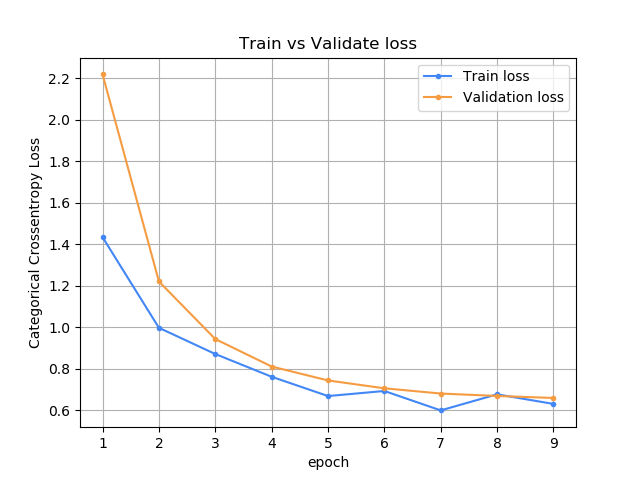

In [33]:
# Epochs
epochs = 9

# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_3_val_loss.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_3_loss.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate loss", "loss")

## 2. Train vs Validation AUC scores

<IPython.core.display.Javascript object>


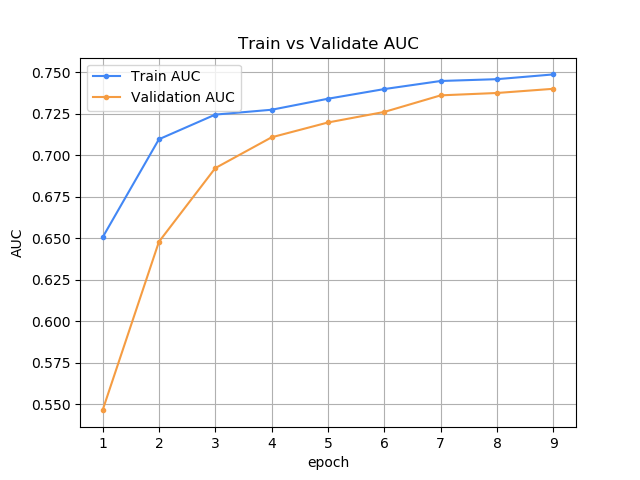

In [34]:
# Plotting the per epoch loss for train and test data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1, epochs+1))
vy = pd.read_csv('Results/model_3_val_auc.csv')
vy = vy['Value']
ty = pd.read_csv('Results/model_3_auc.csv')
ty = ty['Value']

# Plot
plt_dynamic(x, vy, ty, ax, "Train vs Validate AUC", "AUC")

## [X] Plots of Tensorboard

### 1. Train AUC

<img src = 'Results/model_3_auc.svg'>

### 2. Validation AUC

<img src = 'Results/model_3_val_auc.svg'>

### 3. Train Loss

<img src = 'Results/model_3_loss.svg'>

### 4. Validation loss

<img src = 'Results/model_3_val_loss.svg'>

## CONCLUSION

1. In the model 3, we can observe overfitting after 8th epoch as seen clearly in the graph above.
2. To reduce the overfitting of the model I have used dropouts and weights decay.
3. We can observe that the train AUC and the validation AUC have a smooth curve but the loss of validation data has some uneven curves. That means while validation it observes totally new points where it failed to classify them and so the loss increases and vice versa.
4. After the 7th epoch the model starts to overfit, so the early stopping stops the training.

## Model Architecture

<img src = 'Results/model_3.png'>